In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import h5py
import prim.waveform

In [10]:
import glob

In [4]:
def load_hybrid_h5_file(hybrid_file, return_metadata=False):
    with h5py.File(hybrid_file, "r") as f:
        hybrid_metadata = list(f.attrs.items()) + [("filename", hybrid_file)]

        times = f["times"][:]
        hlms = {}
        for l, m in f.attrs["modes"]:
            hlms[l, m] = f[f"hlm_l{l}_m{m}"][:]

        hybrid_wf = prim.waveform.Waveform(times, hlms)

    if return_metadata:
        return hybrid_metadata, hybrid_wf
    else:
        return hybrid_wf

In [ ]:
# ref hybrid: SXS_BBH_2339-Lev3__SEOBNRv4HM_PA

In [134]:
ls /scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-*.h5

/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev1__SEOBNRv4HM_PA.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev1__SEOBNRv5HM.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev2__SEOBNRv4HM_PA.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev2__SEOBNRv5HM.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev3__SEOBNRv4HM_PA.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev3__SEOBNRv5HM.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev4__SEOBNRv4HM_PA.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev4__SEOBNRv5HM.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev5__SEOBNRv4HM_PA.h5
/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev5__SEOBNRv5HM.h5


In [137]:
# ref_hyb_wf = load_hybrid_h5_file('test_ppmHM_2025_03_12/SXS_BBH_2339-Lev3__SEOBNRv4HM_PA.h5')
ref_hyb_wf = load_hybrid_h5_file('test_ppmHM_2025_03_12/SXS_BBH_1154-Lev1__SEOBNRv4HM_PA.h5')

# ref_hyb_wf = load_hybrid_h5_file('/scratch/sebastian.khan/data/ppmHM_2024_11_11/SXS_BBH_2486-Lev5__SEOBNRv5HM.h5')


ref_hyb_wf.compute_amplitude().compute_phase().compute_frequency()

In [138]:
other_hyb_wfs = []
for f in glob.glob('test_ppmHM_2025_03_12/*.h5'):
    # if f != 'test_ppmHM_2025_03_12/SXS_BBH_2339-Lev3__SEOBNRv4HM_PA.h5':
    if f != 'test_ppmHM_2025_03_12/SXS_BBH_1154-Lev1__SEOBNRv4HM_PA.h5':    
        wf = load_hybrid_h5_file(f)
        wf.compute_amplitude().compute_phase().compute_frequency()
        other_hyb_wfs.append(wf)

In [139]:
ref_hyb_wf

(-4.0, 4.0)

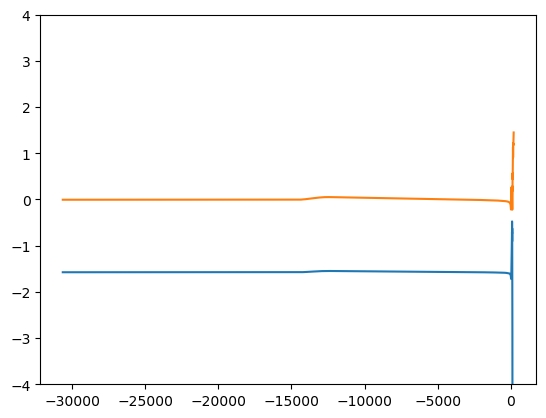

In [140]:
plt.plot(ref_hyb_wf.times, ref_hyb_wf.phases[2,2]/2 - ref_hyb_wf.phases[4,4]/4)
plt.plot(ref_hyb_wf.times, ref_hyb_wf.phases[2,2]/2 - ref_hyb_wf.phases[3,2]/2)
# plt.plot(ref_hyb_wf.times, ref_hyb_wf.phases[2,2]/2 - ref_hyb_wf.phases[2,1]/1)
plt.ylim(-4, 4)

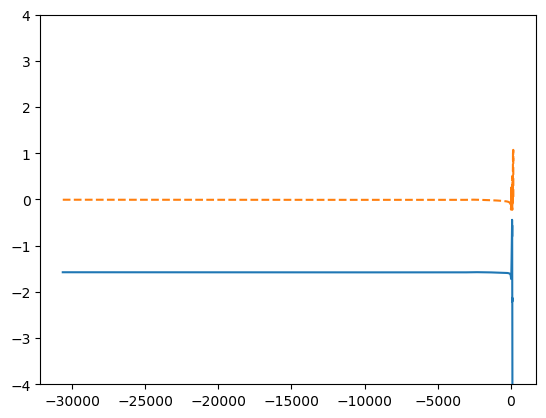

In [30]:
for other_hyb_wf in other_hyb_wfs:
    plt.figure()
    plt.plot(other_hyb_wf.times, other_hyb_wf.phases[2,2]/2 - other_hyb_wf.phases[4,4]/4)
    plt.plot(other_hyb_wf.times, other_hyb_wf.phases[2,2]/2 - other_hyb_wf.phases[3,2]/2, ls='--')
    # plt.plot(other_hyb_wf.times, other_hyb_wf.phases[2,2]/2 - other_hyb_wf.phases[2,1]/1)
    plt.ylim(-4, 4)
    plt.show()
    plt.close()

# test build_hybrids

In [78]:
import matplotlib.pyplot as plt
import numpy as np

In [79]:
# Configure the logger
import logging
logger = logging.getLogger()  # Get the root logger
logger.setLevel(logging.INFO) 

In [80]:
from utils import *

In [347]:
def build_hybrids_2(
    sxs_sim_name=None,
    wfs=None,
    metadata=None,
    approximants=None,
    hybrid_start_freq_Hz=30,
    modes=None,
    deltaT_approximant=1 / 4096,
    n_cycles_before_window=10,
    n_cycles_in_window=30,
    n_tries=10,
    M=10,
    coarse_grid_params=None,
    n_cycles_before_align_window=0,
    n_cycles_in_align_window=200,
):
    """
    Main function to build higher multipole hybrids of SXS waveforms using multiple approximants.

    Inputs are either sxs_sim_name or the pair wfs and metadata.
    If sxs_sim_name is given then uses sxs_load_all_levels to load all
    levels of that simulation.
    If wfs and metadata are given then we assume the user has used
    sxs_load_all_levels before using this function to e.g. obtain
    data from different NR simulations but for the same point in parameter space.

    approximants, list[str]
        List of approximants to use. They only require a 2,2 mode as we use these only
        to get their prediction for the orbital phase.
        Note that the approximant that appears first in the list is the reference approximant.
    deltaT_approximant, float
        Sample rate used to generate the approximant
    """
    logger.info("start")

    if approximants is None:
        approximants = [
            "SEOBNRv5HM",
            "IMRPhenomTHM",
            "SEOBNRv4HM_PA",
            "NRHybSur3dq8",
            # "SpinTaylorT4",
            # "SpinTaylorT1",
        ]
    if modes is None:
        modes = [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3), (5, 5), (5, 4)]

    if coarse_grid_params is None:
        coarse_grid_params = {"on": True, "t0": -300, "t1": 300, "N": 5000}

    logger.info("getting sxs data")

    if sxs_sim_name is not None:
        logger.info("using sxs_load_all_levels")
        metadata, wfs = sxs_load_all_levels(sxs_sim_name)
    else:
        assert wfs is not None, 'please supply wfs dict'
        assert metadata is not None, 'please supply metadatas dict'
        logger.info('wfs and metadata supplied')

    # metadata = {'SXS:BBH:1412/Lev3':metadata['SXS:BBH:1412/Lev3']}
    # wfs = {'SXS:BBH:1412/Lev3':wfs['SXS:BBH:1412/Lev3']}

    number_of_nr_levs_found = len(wfs.keys())
    levs_found = list(np.sort(list(wfs.keys())))
    logger.info(f"{number_of_nr_levs_found = }")
    logger.info(f"{levs_found = }")
    if number_of_nr_levs_found == 1:
        logger.info("Only one Lev found. Therefore, there are no 'non_reference_sims'")

    logger.info("determining reference simulation")
    reference_sim, non_reference_sims = get_reference_and_other(metadata)

    logger.info(f"{reference_sim = }")
    logger.info(f"{non_reference_sims = }")

    logger.info("converting sxs to prim")
    wfs_nr = {}
    for k in levs_found:
        wfs_nr[k] = convert_sxs_to_prim_waveform(wfs[k], modes=modes)

    # hybrids is a list of prim.Waveform containing the hybrids
    hybrids = []
    hybrid_names = []
    fit_metadatas = {}
    logger.info("Looping over NR sims")

    # could loop over all combinations and use multiprocessing to speed this part up.
    # itertools.product(wfs_nr.keys(), approximants)
    
    for i, k in enumerate(wfs_nr.keys()):
        logger.info(f"working: {k} ({i}/{len(wfs_nr.keys()) - 1})")
        wf_nr = wfs_nr[k]

        logger.info(f"start NR time: {wf_nr.times[0]} M")
        logger.info(f"end NR time: {wf_nr.times[-1]} M")

        logger.info("preparing to hybridise")
        logger.info("computing NR start 2,2 frequency")
        NR_start_frequency = (
            phenom.MftoHz(np.abs(wf_nr.frequencies[2, 2][0]), M) / 2 / np.pi
        )
        NR_start_frequency = np.around(NR_start_frequency, 2)
        logger.info(f"{NR_start_frequency = } Hz (Total Mass = {M})")
        NR_start_frequency_Mf = phenom.HztoMf(NR_start_frequency, M)
        logger.info(f"{NR_start_frequency_Mf = } Mf")

        hybrid_start_freq_Mf = phenom.HztoMf(hybrid_start_freq_Hz, M)
        logger.info(f"{hybrid_start_freq_Hz = } Hz")
        logger.info(f"{hybrid_start_freq_Mf = } Mf")
        
        assert hybrid_start_freq_Hz < NR_start_frequency, f"hybrid start frequency too high. The condition ({hybrid_start_freq_Hz = } < {NR_start_frequency = }) is not satisfied."

        logger.info("getting hybridisation windown")
        win1, win2 = prim.hybrid.get_window_times(
            wf_nr,
            n_cycles_before_window=n_cycles_before_window,
            n_cycles_in_window=n_cycles_in_window,
        )
        logger.info(f"{win1 = } M")
        logger.info(f"{win2 = } M")

        logger.info("looping over approximants")
        wf_hybrids = {}
        hybrids_metadatas = {}
        for approximant in approximants:
            tag = f"{k}__{approximant}"
            hybrid_names.append(tag)
            logger.info(f"{tag = }")
            wf_left = get_left_waveform_from_metadata(
                metadata[k],
                M,
                hybrid_start_freq_Hz,
                modes,
                approximant,
                deltaT_approximant,
            )
            logger.info(f"{wf_left.times[0] = } M")
            logger.info("fitting hybrid")
            wf_, hybrids_metadatas[tag] = hybridise(
                wf_left,
                wf_nr,
                fit_modes=modes,
                n_cycles_before_window=n_cycles_before_window,
                n_cycles_in_window=n_cycles_in_window,
                time_shift_guess=0,
                n_tries=n_tries,
                return_metadata=True,
                coarse_grid_params=coarse_grid_params,
            )

            # time shift peak
            # only really need to do this for the reference hybrid
            t0_wf_, _ = (
                wf_.compute_amplitude()
                .compute_phase()
                .compute_frequency()
                .compute_time_of_peak()
            )
            wf_.apply_time_shift(-t0_wf_)
            wf_.compute_amplitude().compute_phase().compute_frequency()
            hybrids.append(copy.deepcopy(wf_))

            logger.info("updating metadata")
            hybrids_metadatas[tag].update({
                'sxs_sim_name':k,
                'approximant':approximant,
                'sxs_metadata':metadata[k],
                'q':metadata[k].dataframe['reference_mass_ratio'],
                'chi1z':metadata[k].dataframe['reference_dimensionless_spin1'][2],
                'chi2z':metadata[k].dataframe['reference_dimensionless_spin2'][2],
            })

               
            fit_metadatas[tag] = copy.deepcopy(hybrids_metadatas[tag])

    logger.info(f"number of hybrids: {len(hybrids)}")
    logger.info("pick a reference hybrid and align at early times")
    reference_hybrid = f"{reference_sim}__{approximants[0]}"

    other_hybrids = list(set(hybrid_names) - set([reference_hybrid]))
    other_hybrids = sorted(other_hybrids)

    logger.info(f"{reference_hybrid = }")
    logger.info(f"{other_hybrids = }")

    # get indices of reference hybrid and other hybrids
    ref_hyb_idx = np.where(np.array(hybrid_names) == reference_hybrid)[0][0]
    other_hyb_idxs = np.where(np.array(hybrid_names) != reference_hybrid)[0]

    logger.info(f"{ref_hyb_idx = }")
    logger.info(f"{other_hyb_idxs = }")



    logger.info("align other_hybrids against the reference_hybrid at early times")
    wf_hybrids_aligned = {}
    # don't use all of the right waveform to make the alignement code faster
    # wf_right = copy.deepcopy(hybrids[ref_hyb_idx]).mask(win1, win2)
    wf_right = copy.deepcopy(hybrids[ref_hyb_idx])
    wf_hybrids_aligned[reference_hybrid] = copy.deepcopy(hybrids[ref_hyb_idx])

    logger.info("getting alignment window")

    win1, win2 = prim.hybrid.get_window_times(
        wf_right,
        n_cycles_before_window=n_cycles_before_align_window,
        n_cycles_in_window=n_cycles_in_align_window,
    )
    alignement_window = {'win1':win1, 'win2':win2}
    logger.info(f"{win1 = } M")
    logger.info(f"{win2 = } M")

    logger.info("aligning other-hybrids with reference hybrid")
    # this can also be sped up using parallelisation
    for i in other_hyb_idxs:
        k = hybrid_names[i]
        logger.info(k)
        wf_hybrids_aligned[k] = align_waveforms(
            hybrids[i],
            wf_right,
            modes,
            n_cycles_before_window=n_cycles_before_align_window,
            n_cycles_in_window=n_cycles_in_align_window,
            time_shift_guess=0,
            n_tries=n_tries,
            coarse_grid_params=coarse_grid_params,
        )

    logger.info("interpolate all hybrids onto same grid")
    dt = (
        wf_hybrids_aligned[reference_hybrid].times[1]
        - wf_hybrids_aligned[reference_hybrid].times[0]
    )
    common_start, common_end = compute_common_time_bounds(
        wf_hybrids_aligned, use_max_end_times=True
    )

    logger.info(f"{common_start = } M")
    logger.info(f"{common_end = } M")
    logger.info(f"{dt = } M")
    hybrid_times = np.arange(common_start, common_end, dt)

    # this can also be sped up using parallelisation
    for k in wf_hybrids_aligned.keys():
        logger.info(k)
        wf_hybrids_aligned[k] = interpolate_wf_onto_same_time_grid(
            wf_hybrids_aligned[k], new_times=hybrid_times
        )

    # logger.info("fixed time shift to ensure peak is at t=0")
    # # finally ensure that the reference hybrid is a t=0
    # t0_reference, _ = wf_hybrids_aligned[reference_hybrid].compute_time_of_peak()
    # for k in wf_hybrids_aligned.keys():
    #     logger.info(k)
    #     wf_hybrids_aligned[k].apply_time_shift(-t0_reference)



    logger.info("creating metadata dict")
    metadata = {'reference_hybrid':reference_hybrid, 'other_hybrids':other_hybrids, 'hybrids_metadatas':fit_metadatas, 'alignement_window':alignement_window}
    logger.info("done")
    return wf_hybrids_aligned, metadata

In [348]:
def sxs_load_all_levels_2(sxs_sim_name: str, ignore_deprecation=False):
    """
    sxs_sim_name: e.g. 'SXS:BBH:1234'
    """
    # load a sim
    sxs_bbh = sxs.load(sxs_sim_name, ignore_deprecation=ignore_deprecation)

    # loop over all possilbe lev numbers to put them into a dict with consistent keys SXS_NAME/LevL

    metadata = {}
    wfs = {}
    for lev_number in sxs_bbh.lev_numbers[:2]:
        try:
            level = f"Lev{lev_number}"
            sim_name = f"{sxs_sim_name}/{level}"
            curr_sxs_bbh = sxs.load(sim_name, ignore_deprecation=ignore_deprecation)
            logger.info(curr_sxs_bbh)
            metadata[sim_name] = curr_sxs_bbh
            # .h will download the data if needed
            w = curr_sxs_bbh.h
            # remove junk
            reference_time = curr_sxs_bbh.metadata.reference_time
            reference_index = w.index_closest_to(reference_time)
            w = w[reference_index:]
            wfs[sim_name] = w
        except:
            continue
    return metadata, wfs

In [349]:
# sxs_sim_name = "SXS:BBH:2496"
# sxs_sim_name = "SXS:BBH:2486"
sxs_sim_name = "SXS:BBH:1154"



In [350]:
metadata = {}
wfs = {}
m_, w_ = sxs_load_all_levels_2(sxs_sim_name)
metadata.update(m_)
wfs.update(w_)

2025-03-13 08:23:54,709 - INFO - Simulation_v2("SXS:BBH:1154v2.0/Lev1")
# n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation
2025-03-13 08:24:03,454 - INFO - Simulation_v2("SXS:BBH:1154v2.0/Lev2")
# n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation


In [351]:
metadata

{'SXS:BBH:1154/Lev1': Simulation_v2("SXS:BBH:1154v2.0/Lev1")
 # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation,
 'SXS:BBH:1154/Lev2': Simulation_v2("SXS:BBH:1154v2.0/Lev2")
 # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation}

In [352]:
# wfs

In [353]:
modes=[(2,2),(3,2),(4,4),(5,4)]

In [354]:
approximants = [
    "SEOBNRv5HM",
    # "SEOBNRv4HM_PA",
    # "IMRPhenomTHM",
    # "NRHybSur3dq8",
    # "SpinTaylorT4",
    # "SpinTaylorT1",
]

In [355]:
coarse_grid_params = {"on": True, "t0": -300, "t1": 300, "N": 5000}

In [356]:
metadata

{'SXS:BBH:1154/Lev1': Simulation_v2("SXS:BBH:1154v2.0/Lev1")
 # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation,
 'SXS:BBH:1154/Lev2': Simulation_v2("SXS:BBH:1154v2.0/Lev2")
 # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation}

In [357]:
wf_hybrids, metadata_hybrids = build_hybrids_2(
    wfs=wfs,
    metadata=metadata,
    approximants=approximants,
    hybrid_start_freq_Hz=30,
    modes=modes,
    deltaT_approximant=1 / 4096,
    n_cycles_before_window=4,
    n_cycles_in_window=8,
    n_tries=10,
    M=10,
    coarse_grid_params=coarse_grid_params,
    n_cycles_before_align_window=10,
    n_cycles_in_align_window=20,
)

2025-03-13 08:24:11,378 - INFO - start
2025-03-13 08:24:11,379 - INFO - getting sxs data
2025-03-13 08:24:11,380 - INFO - wfs and metadata supplied
2025-03-13 08:24:11,381 - INFO - number_of_nr_levs_found = 2
2025-03-13 08:24:11,382 - INFO - levs_found = ['SXS:BBH:1154/Lev1', 'SXS:BBH:1154/Lev2']
2025-03-13 08:24:11,384 - INFO - determining reference simulation
2025-03-13 08:24:11,388 - INFO - reference_sim = 'SXS:BBH:1154/Lev2'
2025-03-13 08:24:11,389 - INFO - non_reference_sims = ['SXS:BBH:1154/Lev1']
2025-03-13 08:24:11,390 - INFO - converting sxs to prim
2025-03-13 08:24:11,586 - INFO - Looping over NR sims
2025-03-13 08:24:11,587 - INFO - working: SXS:BBH:1154/Lev1 (0/1)
2025-03-13 08:24:11,588 - INFO - start NR time: -16008.326653174536 M
2025-03-13 08:24:11,589 - INFO - end NR time: 186.87660773159587 M
2025-03-13 08:24:11,589 - INFO - preparing to hybridise
2025-03-13 08:24:11,590 - INFO - computing NR start 2,2 frequency
2025-03-13 08:24:11,591 - INFO - NR_start_frequency = 65

In [358]:
metadata_hybrids.keys()

dict_keys(['reference_hybrid', 'other_hybrids', 'hybrids_metadatas', 'alignement_window'])

In [359]:
metadata_hybrids

{'reference_hybrid': 'SXS:BBH:1154/Lev2__SEOBNRv5HM',
 'other_hybrids': ['SXS:BBH:1154/Lev1__SEOBNRv5HM'],
 'hybrids_metadatas': {'SXS:BBH:1154/Lev1__SEOBNRv5HM': {'results': <lmfit.model.ModelResult at 0x7f989d1cbc70>,
   'win1': -14778.166063322866,
   'win2': -12424.742475115263,
   'sxs_sim_name': 'SXS:BBH:1154/Lev1',
   'approximant': 'SEOBNRv5HM',
   'sxs_metadata': Simulation_v2("SXS:BBH:1154v2.0/Lev1")
   # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation,
   'q': 1.0000000045100514,
   'chi1z': 2.65408380851e-05,
   'chi2z': 2.64339044381e-05},
  'SXS:BBH:1154/Lev2__SEOBNRv5HM': {'results': <lmfit.model.ModelResult at 0x7f989d146a70>,
   'win1': -14819.83208806356,
   'win2': -12466.740999074958,
   'sxs_sim_name': 'SXS:BBH:1154/Lev2',
   'approximant': 'SEOBNRv5HM',
   'sxs_metadata': Simulation_v2("SXS:BBH:1154v2.0/Lev2")
   # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.6

In [341]:
metadata_hybrids['hybrids_metadatas']

{'SXS:BBH:1154/Lev1__SEOBNRv5HM': {'results': <lmfit.model.ModelResult at 0x7f989ccfb190>,
  'win1': -14778.166063322866,
  'win2': -12424.742475115263,
  'sxs_sim_name': 'SXS:BBH:1154/Lev1',
  'approximant': 'SEOBNRv5HM',
  'sxs_metadata': Simulation_v2("SXS:BBH:1154v2.0/Lev1")
  # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation,
  'q': 1.0000000045100514,
  'chi1z': 2.65408380851e-05,
  'chi2z': 2.64339044381e-05},
 'SXS:BBH:1154/Lev2__SEOBNRv5HM': {'results': <lmfit.model.ModelResult at 0x7f989ccf9cc0>,
  'win1': -14819.83208806356,
  'win2': -12466.740999074958,
  'sxs_sim_name': 'SXS:BBH:1154/Lev2',
  'approximant': 'SEOBNRv5HM',
  'sxs_metadata': Simulation_v2("SXS:BBH:1154v2.0/Lev2")
  # n_orbits=40.7 q=1 chi1=[-7.88e-09, 3.19e-10, 2.65e-05] chi2=[9.99e-09, -3.39e-09, 2.64e-05] e=5.68e-05 simulation,
  'q': 1.0000000045100514,
  'chi1z': 2.65408380851e-05,
  'chi2z': 2.64339044381e-05}}

In [360]:
for wf_hybrid in wf_hybrids.values():
    wf_hybrid.compute_amplitude().compute_phase().compute_frequency()

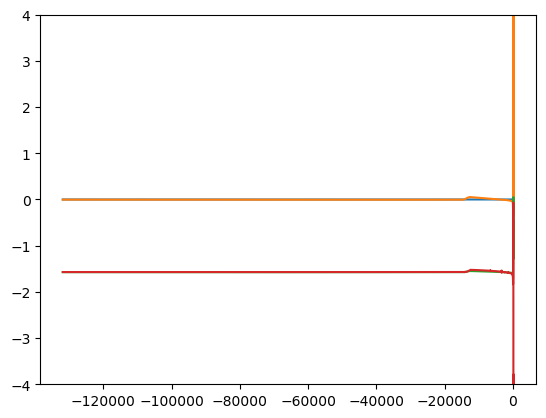

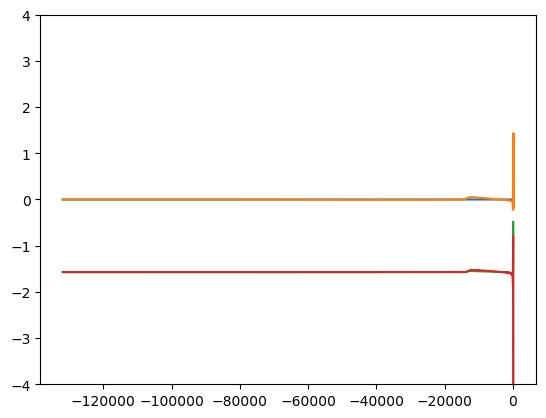

In [361]:
for wf_hybrid in wf_hybrids.values():
    plt.figure()
    for mode in modes:
        plt.plot(wf_hybrid.times, wf_hybrid.phases[2,2]/2 - wf_hybrid.phases[mode]/mode[1])
    plt.ylim(-4, 4)
    plt.show()
    plt.close()

In [362]:
# t0 = wf_hybrid.times[0]-500
# t1 = t0 + 1000
# for wf_hybrid in wf_hybrids.values():
#     mask = (wf_hybrid.times > t0) & (wf_hybrid.times < t1)
#     for mode in modes:
#         plt.figure()
#         plt.plot(wf_hybrid.times[mask], wf_hybrid.hlms[mode].real[mask])
#         plt.plot(wf_hybrid.times[mask], wf_hybrid.hlms[mode].imag[mask])
#         plt.xlim(t0, t1)
#         plt.title(mode)
#         plt.show()
#         plt.close()

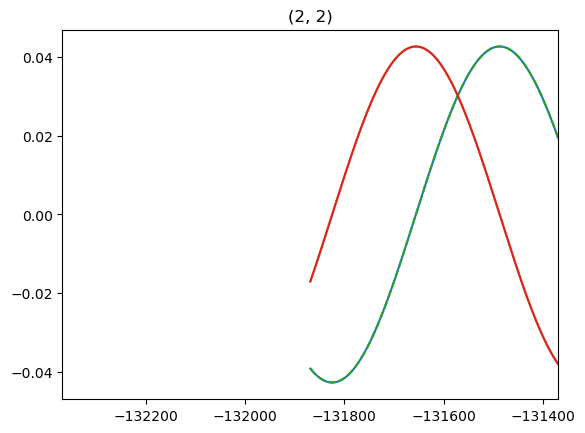

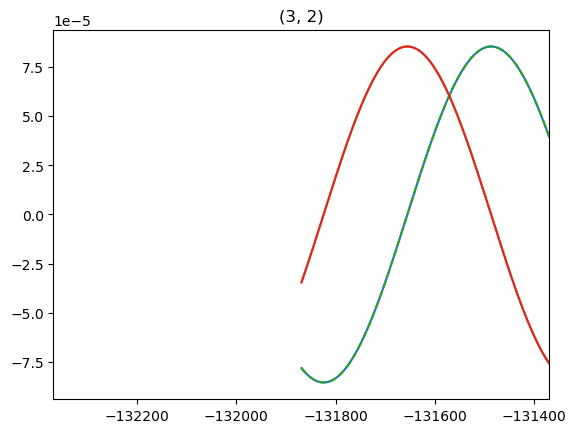

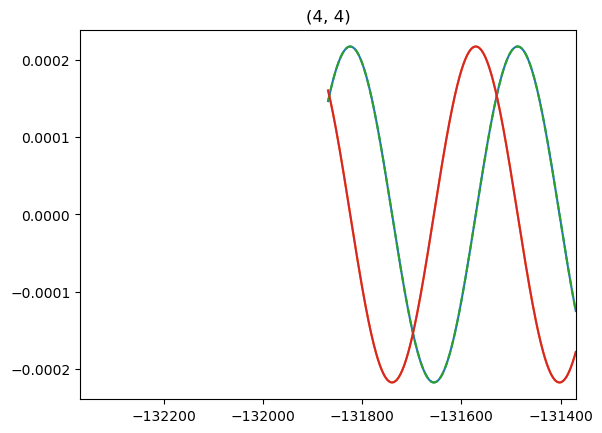

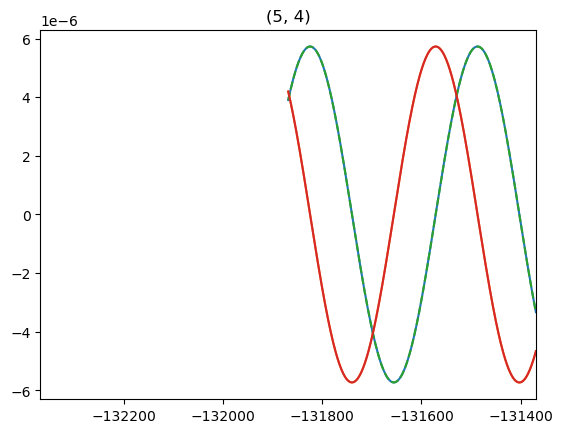

In [363]:
t0 = wf_hybrid.times[0]-500
t1 = t0 + 1000
for mode in modes:
    plt.figure()
    for i, wf_hybrid in enumerate(wf_hybrids.values()):
        mask = (wf_hybrid.times > t0) & (wf_hybrid.times < t1)

        plt.plot(wf_hybrid.times[mask], wf_hybrid.hlms[mode].real[mask], ls='-' if i==0 else '--')
        plt.plot(wf_hybrid.times[mask], wf_hybrid.hlms[mode].imag[mask])
        plt.xlim(t0, t1)
    plt.title(mode)
    plt.show()
    plt.close()

In [364]:
k = list(wf_hybrids.keys())[1]
wf_hybrid = wf_hybrids[k]

In [365]:
t0 = wf_hybrid.times[0]-500
t1 = t0 + 1000

In [366]:
phi0 = np.angle(wf_hybrid.hlms[2,2])[0]/2
phi0

-1.3658195036115632

In [367]:
wf_hybrid.apply_phase_shift(-phi0)

In [368]:
np.angle(wf_hybrid.hlms[2,2])[0]/2

5.850527209023576e-17

In [369]:
mask = (wf_hybrid.times > t0) & (wf_hybrid.times < t1)

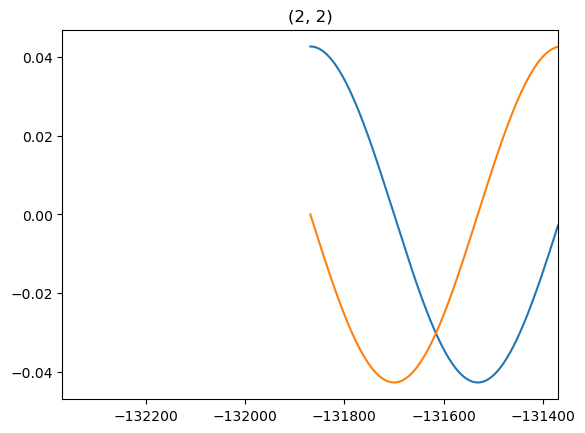

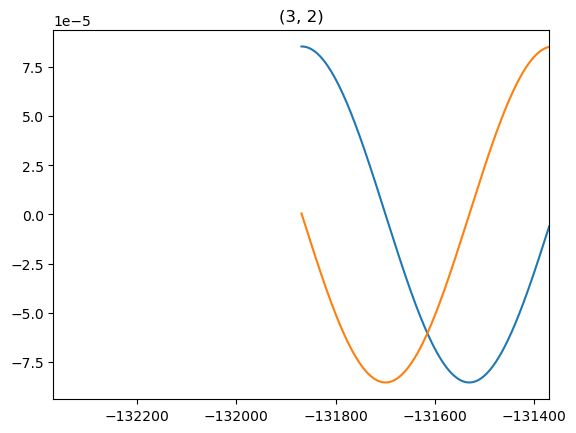

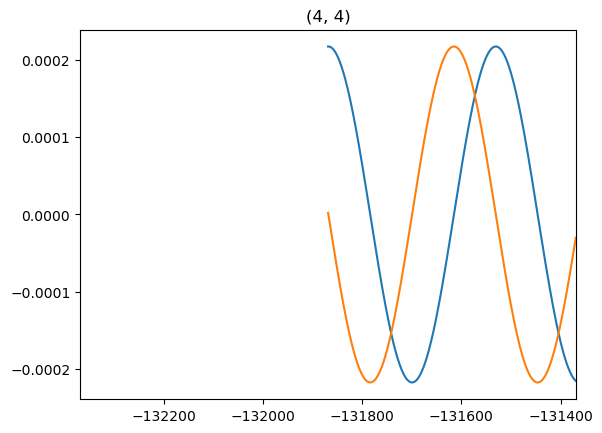

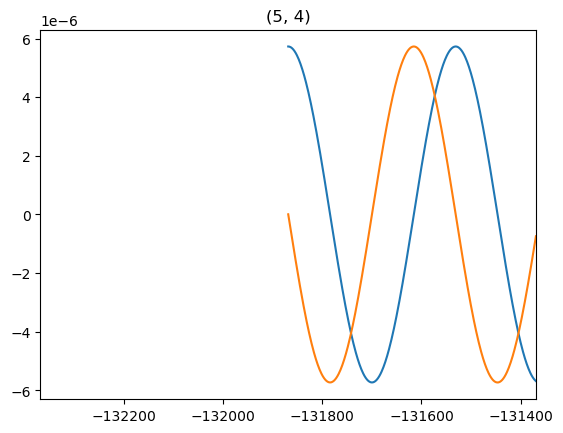

In [370]:
for mode in modes:
    plt.figure()
    plt.plot(wf_hybrid.times[mask], wf_hybrid.hlms[mode].real[mask])
    plt.plot(wf_hybrid.times[mask], wf_hybrid.hlms[mode].imag[mask])
    plt.xlim(t0, t1)
    plt.title(mode)
    plt.show()
    plt.close()

In [372]:
wf_hybrid.compute_phase()

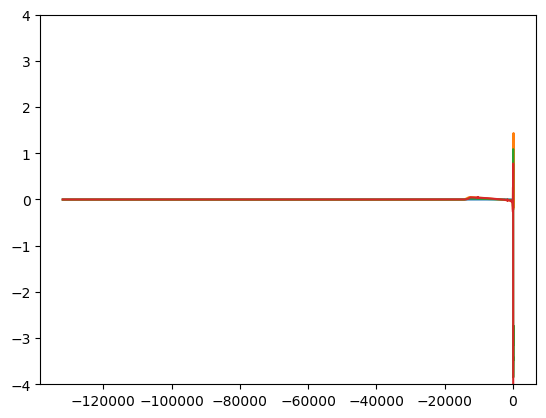

In [373]:
plt.figure()
for mode in modes:
    plt.plot(wf_hybrid.times, wf_hybrid.phases[2,2]/2 - wf_hybrid.phases[mode]/mode[1])
plt.ylim(-4, 4)
plt.show()
plt.close()